<a href="https://colab.research.google.com/github/nattntn/7-23yrs_EffNet/blob/main/Multi-Task_Duo/7_23_01_Eff_Multi_Train_250Freeze_(ALL)_Unflipped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import shutil

In [2]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Imports

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import datetime

In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

#กำหนดค่าพารามิเตอร์


In [5]:
batch_size = 16
width = 224 # จตุรัส โมเตลจะเรียนรู้ภาพได้ดีที่สุด
height = 224
epochs = 250 # รอบในการเทรน
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [6]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 19.12 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


In [7]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [8]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape) # convolution base = base ที่เอาไว้เรียนแบบยังไม่ปรับ

16717576/16717576 [==============================] - 0s 0us/step


In [9]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_normaliz

In [10]:
for layer in conv_base.layers:
    print(layer.name)

input_1
conv2d
batch_normalization
swish
depthwise_conv2d
batch_normalization_1
swish_1
lambda
conv2d_1
swish_2
conv2d_2
activation
multiply
conv2d_3
batch_normalization_2
conv2d_4
batch_normalization_3
swish_3
depthwise_conv2d_1
batch_normalization_4
swish_4
lambda_1
conv2d_5
swish_5
conv2d_6
activation_1
multiply_1
conv2d_7
batch_normalization_5
conv2d_8
batch_normalization_6
swish_6
depthwise_conv2d_2
batch_normalization_7
swish_7
lambda_2
conv2d_9
swish_8
conv2d_10
activation_2
multiply_2
conv2d_11
batch_normalization_8
drop_connect
add
conv2d_12
batch_normalization_9
swish_9
depthwise_conv2d_3
batch_normalization_10
swish_10
lambda_3
conv2d_13
swish_11
conv2d_14
activation_3
multiply_3
conv2d_15
batch_normalization_11
conv2d_16
batch_normalization_12
swish_12
depthwise_conv2d_4
batch_normalization_13
swish_13
lambda_4
conv2d_17
swish_14
conv2d_18
activation_4
multiply_4
conv2d_19
batch_normalization_14
drop_connect_1
add_1
conv2d_20
batch_normalization_15
swish_15
depthwise_conv2d

In [11]:
# ฟังก์ชัน ReLU ทำการปรับค่า x โดยให้เป็น 0 หาก x น้อยกว่า 0 และให้เป็น  x หาก x มากกว่าหรือเท่ากับ 0 นั่นหมายความว่า ReLU จะ "กระตุ้น" ค่าที่มากกว่าหรือเท่ากับ 0 ให้ผ่านไป และจะปรับค่าที่น้อยกว่า 0 เป็น 0 นั่นเอง

In [12]:
x = conv_base.output
### add the tail layer ###
Flatten_layer1 = layers.Flatten()(x)
BatchNormalization_layer1 = layers.BatchNormalization(name='BatchNormalization_1')(Flatten_layer1)
dropout_layer_1 = layers.Dropout(0.20,name = 'head_dropout')(BatchNormalization_layer1)
Dense_layer1 = layers.Dense(64, activation='relu',name='Dense_layer1')(dropout_layer_1)
BatchNormalization_layer2 = layers.BatchNormalization(name='BatchNormalization_2')(Dense_layer1)
prediction_layer_Age = layers.Dense(1, activation='linear',name='Prediction_Age')(BatchNormalization_layer2)
prediction_layer_Gender = layers.Dense(1, activation='sigmoid',name='Prediction_Gender')(BatchNormalization_layer2)

In [13]:
### lastlayer
model = models.Model(inputs= conv_base.input, outputs=[prediction_layer_Age, prediction_layer_Gender] , name = 'EffNet_Multi-task')

In [14]:
print('This is the number of trainable layers '
      'of the conv base:', len(conv_base.trainable_weights))

print('This is the number of trainable layers '
      'of the model:', len(model.trainable_weights))

This is the number of trainable layers of the conv base: 211
This is the number of trainable layers of the model: 221


In [15]:
model.summary() #ดู Summary

Model: "EffNet_Multi-task"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_normal

In [16]:
##Freeze
print('This is the number of trainable layers '
          'before freezing the conv base:', len(model.trainable_weights))
for layer in conv_base.layers:
    layer.trainable = False
print('This is the number of trainable layers '
          'after freezing the conv base:', len(model.trainable_weights))
print('-'*80)
model.summary()

This is the number of trainable layers before freezing the conv base: 221
This is the number of trainable layers after freezing the conv base: 10
--------------------------------------------------------------------------------
Model: "EffNet_Multi-task"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                      

#สร้างโฟลเดอร์ Train Valodation และ Test

In [17]:
df = pd.read_csv(r'/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Multi_task(All)(7-23)/table_train_7_23_fold.csv')
df

,Unnamed: 0,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
0,0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2,0
1,1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4,0
2,2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10,0
3,3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9,0
4,4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10,0
...,...,...,...,...,...,...,...,...,...
3780,3780,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE429.jpg,10,1
3781,3781,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E430.jpg,6,1
3782,3782,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE430.jpg,10,1
3783,3783,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E431.jpg,10,1


In [18]:
df = df.iloc[:,1:]

In [19]:
# train7_23 = df[(df['Age(year)']>= 7)&(df['Age(year)']<= 23)]
# train7_23

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2,0
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4,0
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10,0
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9,0
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10,0
...,...,...,...,...,...,...,...,...
3780,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE429.jpg,10,1
3781,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E430.jpg,6,1
3782,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE430.jpg,10,1
3783,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E431.jpg,10,1


In [20]:
#train7_23.to_csv('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Multi_task(All)(7-23)/table_train_7_23_fold.csv') #save ลงไดร์ฟ

In [19]:
val = df[df['Fold']==3]
val

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
6,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V6.jpg,3,0
20,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V26.jpg,3,0
38,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V43.jpg,3,0
43,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV52.jpg,3,0
51,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV56.jpg,3,0
...,...,...,...,...,...,...,...,...
3707,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E146.jpg,3,1
3735,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E306.jpg,3,1
3752,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE387.jpg,3,1
3775,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E423.jpg,3,1


In [20]:
train = df[~df['Fold'].isin(val['Fold'])]
train

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2,0
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4,0
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10,0
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9,0
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10,0
...,...,...,...,...,...,...,...,...
3780,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE429.jpg,10,1
3781,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E430.jpg,6,1
3782,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE430.jpg,10,1
3783,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E431.jpg,10,1


In [21]:
DATA_PATH = "/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images/Normal"
os.chdir(DATA_PATH)
#train_dir = os.path.join(DATA_PATH, 'train')
#print(train_dir)
#validation_dir = os.path.join(DATA_PATH, 'validation')
#print(validation_dir)


#Train

In [22]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      # horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = ['Age(year)','Gender_Class'],
        class_mode = 'multi_output',
        color_mode= 'rgb',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = ['Age(year)','Gender_Class'],
        class_mode = 'multi_output',
        color_mode= 'rgb',
        target_size=(height, width),
        batch_size=batch_size)

Found 3408 validated image filenames.
Found 377 validated image filenames.


In [24]:
model.output_names

['Prediction_Age', 'Prediction_Gender']

In [25]:
model.compile(
   loss={'Prediction_Age': 'mse', 'Prediction_Gender': 'binary_crossentropy'},
   loss_weights={'Prediction_Age': 0.75, 'Prediction_Gender': 0.25},
   optimizer= Adam(learning_rate=1e-4),
   metrics={'Prediction_Age': ['mse'], 'Prediction_Gender': ['accuracy']}
   )

In [26]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= len(train) //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= len(val) //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-26-4a1ce764999b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
213/213 [==============================] - 629s 3s/step - loss: 169.3283 - Prediction_Age_loss: 225.5159 - Prediction_Gender_loss: 0.7652 - Prediction_Age_mse: 225.5159 - Prediction_Gender_accuracy: 0.5499 - val_loss: 211.2060 - val_Prediction_Age_loss: 281.3983 - val_Prediction_Gender_loss: 0.6289 - val_Prediction_Age_mse: 281.3983 - val_Prediction_Gender_accuracy: 0.6467
Epoch 2/250
213/213 [==============================] - 24s 112ms/step - loss: 162.6402 - Prediction_Age_loss: 216.6293 - Prediction_Gender_loss: 0.6727 - Prediction_Age_mse: 216.6293 - Prediction_Gender_accuracy: 0.6074 - val_loss: 158.7694 - val_Prediction_Age_loss: 211.4206 - val_Prediction_Gender_loss: 0.8157 - val_Prediction_Age_mse: 211.4206 - val_Prediction_Gender_accuracy: 0.5054
Epoch 3/250
213/213 [==============================] - 24s 112ms/step - loss: 156.1782 - Prediction_Age_loss: 208.0185 - Prediction_Gender_loss: 0.6574 - Prediction_Age_mse: 208.0185 - Prediction_Gender_accuracy: 0.6268 - 

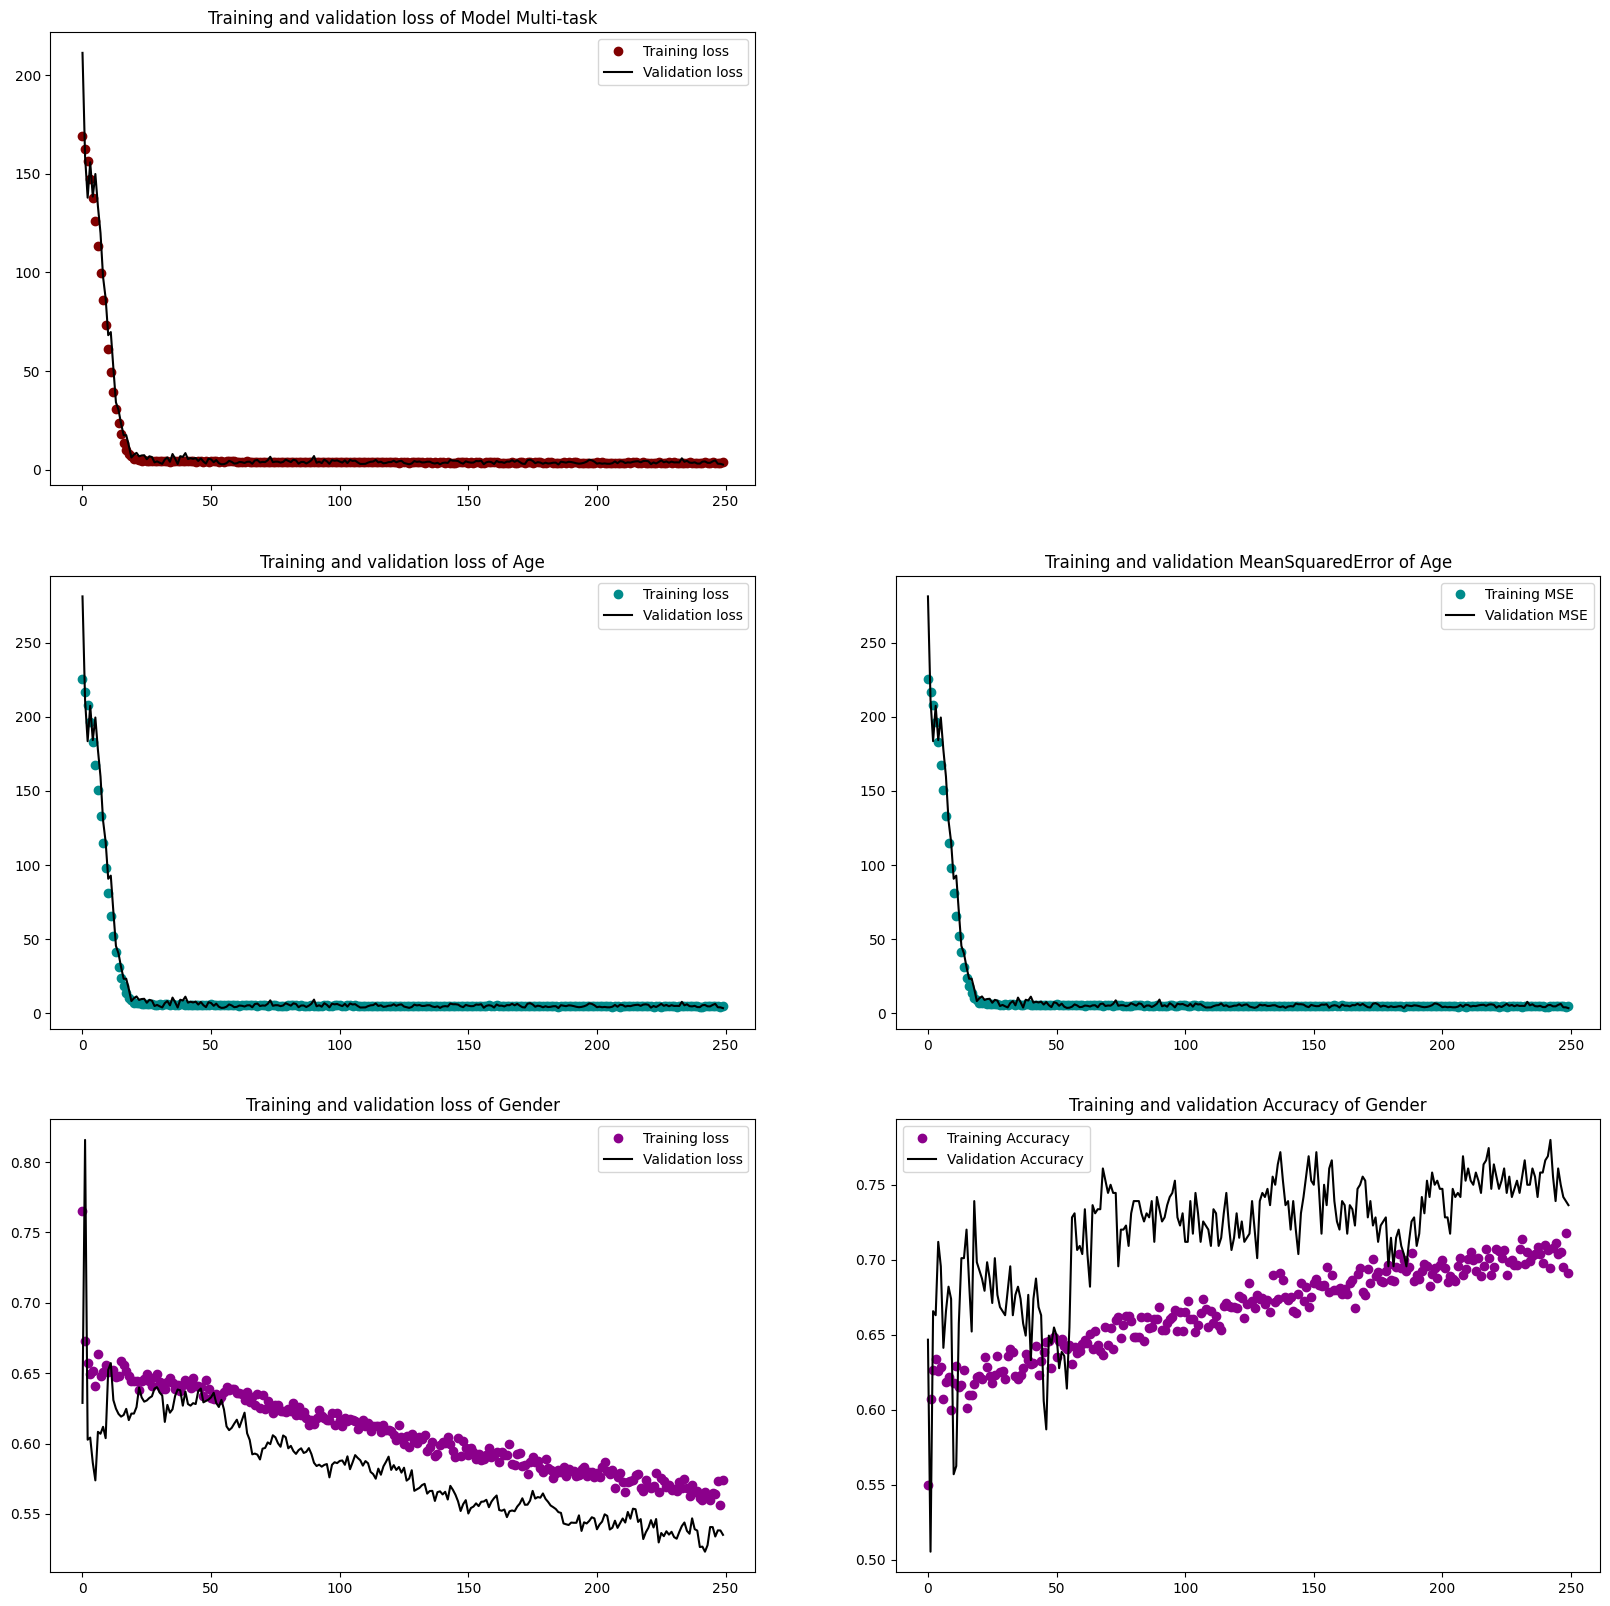

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

loss_age = history.history['Prediction_Age_loss']
val_loss_age = history.history['val_Prediction_Age_loss']

loss_gender = history.history['Prediction_Gender_loss']
val_loss_gender = history.history['val_Prediction_Gender_loss']

mse_age = history.history['Prediction_Age_mse']
val_mse_age = history.history['val_Prediction_Age_mse']

acc_gender = history.history['Prediction_Gender_accuracy']
val_acc_gender = history.history['val_Prediction_Gender_accuracy']


epochs_x = range(len(loss))
# plt.figure(10,20)
from matplotlib import pyplot as plt #เพื่อ plot graph
import matplotlib #เพื่อปรับแต่งขนาดของกราฟ
matplotlib.rcParams['figure.figsize']=[20,20]

# loss val_loss
plt.subplot(3,2,1)
plt.plot(epochs_x, loss, 'o', color ='maroon', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss of Model Multi-task')
plt.legend()
#------------------------------------------------------------------
# age
plt.subplot(3,2,3)
plt.plot(epochs_x, loss_age, 'o', color ='darkcyan', label='Training loss')
plt.plot(epochs_x, val_loss_age, 'k', label='Validation loss')
plt.title('Training and validation loss of Age')
plt.legend()

plt.subplot(3,2,4)
plt.plot(epochs_x, mse_age, 'o', color ='darkcyan', label='Training MSE')
plt.plot(epochs_x, val_mse_age, 'k', label='Validation MSE')
plt.title('Training and validation MeanSquaredError of Age')
plt.legend()
#------------------------------------------------------------------
# gender
plt.subplot(3,2,5)
plt.plot(epochs_x, loss_gender, 'o', color ='darkmagenta', label='Training loss')
plt.plot(epochs_x, val_loss_gender, 'k', label='Validation loss')
plt.title('Training and validation loss of Gender')
plt.legend()

plt.subplot(3,2,6)
plt.plot(epochs_x, acc_gender, 'o', color ='darkmagenta', label='Training Accuracy')
plt.plot(epochs_x, val_acc_gender, 'k', label='Validation Accuracy')
plt.title('Training and validation Accuracy of Gender')
plt.legend()
#------------------------------------------------------------------

# # plt.plot(epochs_x, loss, 'go', label='Training loss')
# plt.plot(epochs_x, loss, 'o', color ='darkviolet', label='Training loss')
# plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

plt.show()

In [28]:
epochs_x

range(0, 250)

#Download the model


In [29]:
os.makedirs('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model', exist_ok=True)
model.save('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Multi_task(All)(7-23)/01_Multi_1e-4_250_Freeze.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
